In [4]:
from zlib import crc32
theory = crc32("Шульгин".lower().encode("utf-8"))%3+1
practice = crc32("Shulgin".lower().encode("utf-8"))%3+1

theory, practice

(2, 2)

**Практическое задание**  
Реализовать пример выбора модели с вариационным нормальным распределением (Graves)

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from sklearn.metrics import log_loss
import scipy.stats as sps
import seaborn as sns

Рассмотрим следующую игрушечную задачу бинарной классификации (одномерной логистической регрессии):
$$
y \sim \mathrm{Be}(p) \\ 
x \sim \mathcal{N}(0, 1) \\
$$
$\mathrm{P}(y=±1) = \sigma(±1 \cdot x \cdot w) $ $-$сигмоида

In [161]:
n = 100
p = 0.6

x = np.random.rand(n)
y = np.random.binomial(1, p, size=n)

In [162]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

Априорное распределение: $p(w) \sim \mathcal{N} (\mu, \sigma^2)$  
Вариационное распределение: $q(w) \sim \mathcal{N} (\mu_q, \sigma_q^2)$

In [164]:
mu, mu_q = 0, 1/2
sigma, sigma_q = 1, 1

w = np.random.rand(n)

In [165]:
def KL_divergence(mu, mu_q, sigma, sigma_q):
    return 0.5 * (sigma_q / sigma + (mu - mu_q)**2 / sigma - n + np.log(abs(sigma / sigma_q)))

Вариационная оценка (согласно слайду 16 из https://github.com/bahleg/tex_slides/raw/master/oct_19/slides1_elbo.pdf):
$$
\mathrm{D}_{\text{KL}} (q(w) || p(w)) - \sum\limits_{i=1}^n \log p(y_i | x_i, \hat{w}) \to \min\limits_{\mu_q}
$$

In [169]:
target_f = lambda t: KL_divergence(mu, t, sigma, sigma_q) - log_loss(y, sigmoid(y * x * t), normalize=False)

Численная минимизация

In [170]:
opt_res = optimize.minimize_scalar(target_f)
opt_res

     fun: -509.16753680637817
    nfev: 17
     nit: 10
 success: True
       x: -29.2396917383283

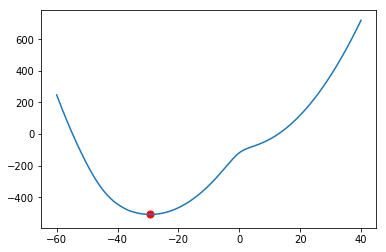

In [182]:
grid = np.linspace(-60, 40, 1000)
plt.plot(grid, [target_f(k) for k in grid])
plt.scatter(opt_res.x, target_f(opt_res.x), s=50, c='r');

По графику видно, что оптимум найден корректно.

К сожалению как-то нормально оценить качество аппроксимации апостериорного распределения в данном случае я не могу. Поэтому я решил проделать это для случая, когда posterior вычислим аналитически.

Второй игрушечный пример.
$$
y \sim \mathcal{N}(\mu, \sigma^2), \sigma - \text{ известно} \\
\mu \sim \mathcal{N}(\mu_0, \sigma_0^2) - \text{ prior}
$$
Тогда posterior: ${\mu \sim \mathcal {N}}(\mu_{0}',{\sigma _{0}^{2}}'), \ (\mu_{0}',{\sigma _{0}^{2}}') = \left({\displaystyle {\frac {1}{{\frac {1}{\sigma _{0}^{2}}}+{\frac {n}{\sigma ^{2}}}}}\left({\frac {\mu _{0}}{\sigma _{0}^{2}}}+{\frac {\sum _{i=1}^{n}y_{i}}{\sigma ^{2}}}\right),\left({\frac {1}{\sigma _{0}^{2}}}+{\frac {n}{\sigma ^{2}}}\right)^{-1}} \right)$



In [208]:
mu_prior = 0; sigma_prior = 100
sigma = 4
mu = -3 # Parameter
n = 100

In [209]:
y = mu + sigma**(1/2) * np.random.randn(n)

In [212]:
mu_posterior = (mu_prior / sigma_prior + y.sum() / sigma) / (1/sigma_prior + n/sigma)
sigma_posterior = 1 / (1/sigma_prior + n/sigma)

Для данного примера меняется только выражения для правдоподобия, остальное же остаётся неизменным.

In [218]:
def log_LL(t):
    return sps.norm(t, sigma**(1/2)).logpdf(y).sum()

In [219]:
target_f = lambda t: KL_divergence(mu_prior, t, sigma_prior, sigma_posterior) - log_LL(t)

In [220]:
opt_res = optimize.minimize_scalar(target_f)
opt_res

     fun: 166.09324505242017
    nfev: 10
     nit: 4
 success: True
       x: -2.871134723581238

In [221]:
mu_posterior

-2.871134723581234

Найденное значение для параметра вариационного распределения совпадает с аналитически найденным.

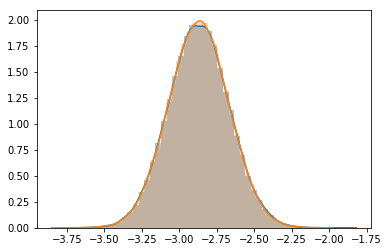

In [223]:
sns.distplot(sps.norm(mu_posterior, sigma_posterior**(1/2)).rvs(10**5), kde=True);
sns.distplot(sps.norm(opt_res.x, sigma_posterior**(1/2)).rvs(10**5), kde=True, hist_kws={"alpha":0.3});

По kde-plot'y также видно, что аппроксимация получилась.